In [1]:
import sys  
sys.path.insert(0, '../utils')
import warnings
warnings.filterwarnings("ignore")

from fsdd import FSDD
from display import show_results
from tqdm.auto import tqdm
import librosa, numpy as np, sequentia as seq, sklearn.preprocessing
import matplotlib.pyplot as plt, librosa.display; plt.style.use('ggplot')

# Set seed, sample rate and labels
rng = np.random.RandomState(0)
sr = 8000
fsdd_labels = [str(i) for i in range(10)]

Load training (80%), validation (10%) and test (10%) recordings in `numpy.ndarray` format.

In [2]:
XX_train, yy_train = FSDD('train').load()
XX_val, yy_val = FSDD('validation').load()
XX_test, yy_test = FSDD('test').load()

Create a pipeline class to generate MFCCs, discard the first (offset) coefficient and standardize them over each window.

In [3]:
class PrepareMFCCs(seq.Transform):
    def __init__(self, n_mfcc):
        super().__init__()
        self.n_mfcc = self._val.restricted_integer(
            n_mfcc, lambda x: x > 0, 
            desc='number of MFCCs', expected='positive')
        
    def _describe(self):
        return 'Creating and standardizing {} MFCCs'.format(self.n_mfcc)

    def transform(self, X, verbose=False):
        def mfcc(x):
            x = x.flatten()
            x = librosa.feature.mfcc(x, sr=sr, n_mfcc=self.n_mfcc+1)[1:]
            x = sklearn.preprocessing.scale(x, axis=0)
            return x.T
        return self._apply(mfcc, X, verbose)

Use the class to create a pipeline for generating 39 standardized MFCCs.

In [4]:
mfcc = PrepareMFCCs(n_mfcc=39)

Preview 39 MFCCs for a sample training digit.

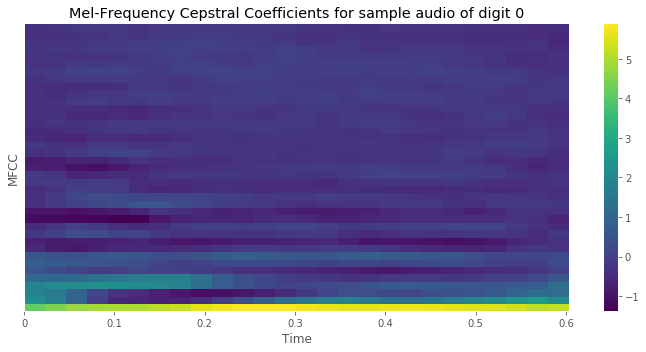

In [5]:
# Generate 39 MFCCs for a sample training digit
X = mfcc(XX_train[0]).T

# Plot the MFCCs for the digit
plt.figure(figsize=(10, 5))
librosa.display.specshow(X, x_axis='time', cmap='viridis')
plt.colorbar()
plt.title(f'Mel-Frequency Cepstral Coefficients for sample audio of digit {yy_train[0]}')
plt.ylabel('MFCC')
plt.tight_layout()
plt.show()

Generate MFCCs for training, validation and test recordings.

In [6]:
%%time
mfcc_train, mfcc_val, mfcc_test = mfcc(XX_train), mfcc(XX_val), mfcc(XX_test)
print(f'Number of training recordings: {len(mfcc_train)}')
print(f'Number of validation recordings: {len(mfcc_val)}')
print(f'Number of test recordings: {len(mfcc_test)}')

Number of training recordings: 1160
Number of validation recordings: 400
Number of test recordings: 440
CPU times: user 4min 55s, sys: 54.1 s, total: 5min 49s
Wall time: 24.2 s


Perform a grid search over various hyper-parameters and save models which led to an accuracy improvement on validation set.

In [7]:
%%time
best = (None, {}, -1)
for k in (5, 10):
    for radius in (1, 10, 25):
        for name, weighting in (('uniform', lambda x: 1), ('exp', lambda x: np.exp(-x))):
            clf = seq.KNNClassifier(k=k, radius=radius, weighting=weighting)
            clf.fit(mfcc_train, yy_train)
            acc, _ = clf.evaluate(mfcc_val, yy_val, labels=fsdd_labels, n_jobs=-1)
            file = f'../models/knn-{k}-{radius}-{name}.h5'
            print(f'k: {k}, radius: {radius}, weighting: {name}, accuracy: {acc}')
            if acc > best[2]:
                # Only save models which improved!
                clf.save(file)
                best = (file, {'k': k, 'radius': radius, 'weighting': (name, weighting)}, acc)

print(f'Best model: {best[1]}')

k: 5, radius: 1, weighting: uniform, accuracy: 0.945
k: 5, radius: 1, weighting: exp, accuracy: 0.94
k: 5, radius: 10, weighting: uniform, accuracy: 0.9475
k: 5, radius: 10, weighting: exp, accuracy: 0.94
k: 5, radius: 25, weighting: uniform, accuracy: 0.9475
k: 5, radius: 25, weighting: exp, accuracy: 0.94
k: 10, radius: 1, weighting: uniform, accuracy: 0.94
k: 10, radius: 1, weighting: exp, accuracy: 0.945
k: 10, radius: 10, weighting: uniform, accuracy: 0.94
k: 10, radius: 10, weighting: exp, accuracy: 0.9425
k: 10, radius: 25, weighting: uniform, accuracy: 0.9425
k: 10, radius: 25, weighting: exp, accuracy: 0.9425
Best model: {'k': 5, 'radius': 10, 'weighting': ('uniform', <function <lambda> at 0x7f6c2bd79050>)}
CPU times: user 1min 9s, sys: 2.26 s, total: 1min 11s
Wall time: 1h 8min 12s


Load the best model and use it to classify test recordings.

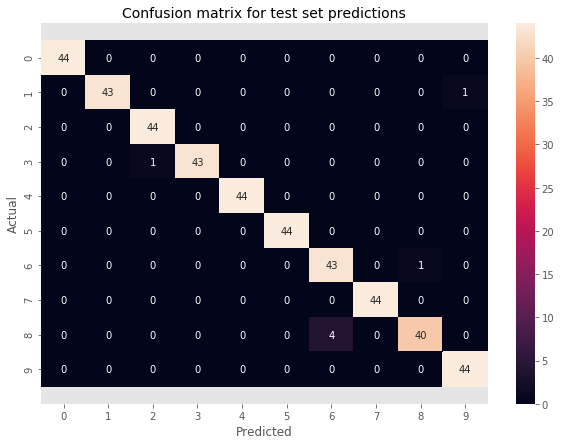

Accuracy: 98.41%
CPU times: user 5.43 s, sys: 332 ms, total: 5.76 s
Wall time: 5min 24s


In [8]:
%%time
# Load the best model
clf = seq.KNNClassifier.load(best[0], weighting=best[1]['weighting'][1])

# Classify test recordings
acc, cm = clf.evaluate(mfcc_test, yy_test, labels=fsdd_labels, n_jobs=-1)
show_results(acc, cm, dataset='test', labels=fsdd_labels)